# Validate PKS product predictions against MIBiG
Tyler W. H. Backman

Joint BioEnergy Institute

In [1]:
# load dependencies

import re
import os
import json
import imp
import pickle
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [2]:
# load Clara's PKS object code

helper = imp.load_source('helper', './pks/helper.py')
domain = imp.load_source('domain', './pks/domain.py')
pks = imp.load_source('pks', './pks/pks.py')

In [3]:
# load Clara's pickled results from cluster parsing

pruned_clusters = pickle.load(open("pruned_clusters_mibig.p", "rb" ))

RDKit ERROR: [00:36:22] Explicit valence for atom # 2 O, 3, is greater than permitted


valid structures: 149


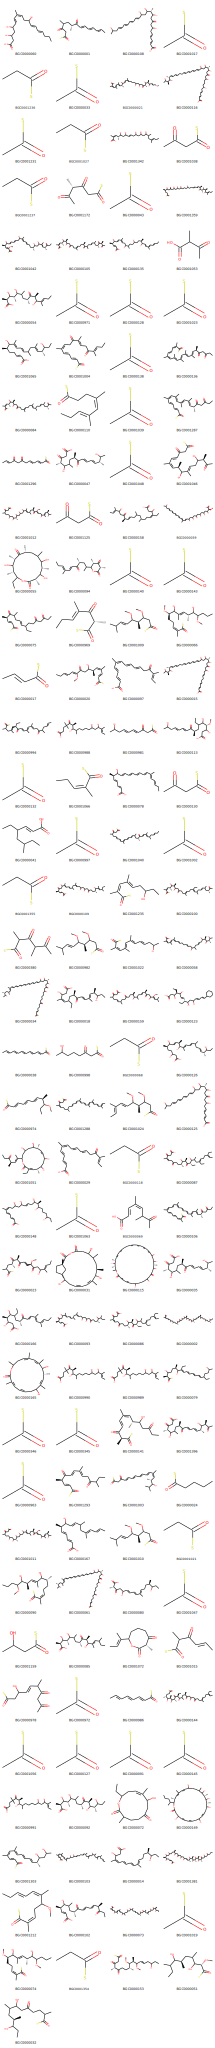

In [4]:
# compute and plot predicted final product structures

def getProduct(cluster):
    try:
        m = cluster.compute_product(None)
    except:
        return(False)
    return(m)

finalStructures = {key: getProduct(cluster) for key, cluster in pruned_clusters.items()}
finalStructures = {re.search('^\w+', key).group(0): cluster for key, cluster in finalStructures.items() if cluster}
print("valid structures: " + str(len(finalStructures.keys())))
Draw.MolsToGridImage(list(finalStructures.values()), legends=list(finalStructures.keys()), molsPerRow=4, useSVG=True)

In [5]:
# import and parse mibig structures

mibigFolder = "mibig/"
allFiles = os.listdir(mibigFolder)
jsonFiles = list(filter(re.compile("^\w+.*\.json$").match, allFiles))

geneClusters = {}
for jsonFile in jsonFiles:
    name = re.search('^\w+', jsonFile).group(0)
    clusterFile = open(mibigFolder + jsonFile).read()
    pksData = json.loads(clusterFile)
    try:
        structures = [x['chem_struct'] for x in pksData['general_params']['compounds']]
    except KeyError:
        continue
    molStructures = [Chem.MolFromSmiles(structure) for structure in structures]
    geneClusters[name] = molStructures

In [6]:
# find intersection - set of both predicted and annotated structures

geneClusterIntersect = list(set(geneClusters.keys()).intersection(set(finalStructures.keys())))
print("overlapping structures: " + str(len(geneClusterIntersect)))

overlapping structures: 32


In [7]:
# compute MCS for every intersection

def getMCS(geneClusterName, finalStructures = finalStructures, geneClusters = geneClusters):
    predicted = finalStructures[geneClusterName]
    known = geneClusters[geneClusterName]
    
    # if geneCluster has multiple predicted products, keep only the one with the largest MCS
    size = 0
    for structure in known:
        mcs = rdFMCS.FindMCS([structure, predicted])
        if mcs.numAtoms > size:
            bestMCS = mcs
            size = mcs.numAtoms
            bestMatch = structure
    
    resultFraction = float(size) / float(predicted.GetNumAtoms())
    
    return resultFraction, bestMCS.smartsString, bestMatch

mcsResults = {geneClusterName: getMCS(geneClusterName) for geneClusterName in geneClusterIntersect}

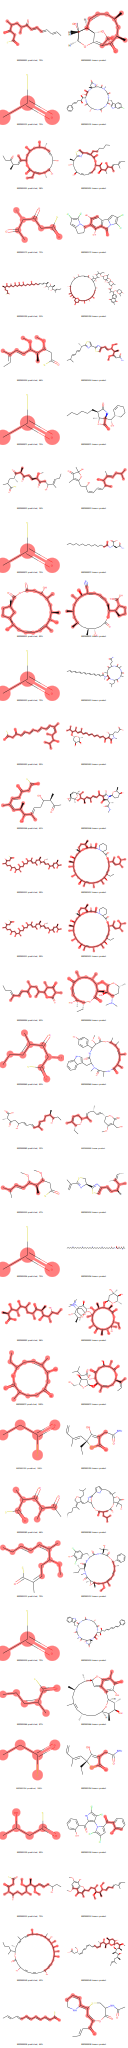

In [8]:
# highlight MCS as a subset of the predicted products

def getHighlightAtoms(structure, mcs):
    return structure.GetSubstructMatch(Chem.MolFromSmarts(mcs))

# get matching MCS for predicted products
mcsStructs = [mcsResults[geneClusterName][1] for geneClusterName in geneClusterIntersect]
predictedStructs = [finalStructures[geneClusterName] for geneClusterName in geneClusterIntersect]
matchingAtoms = list(map(getHighlightAtoms, predictedStructs, mcsStructs))

# get matching mcs for known products
knownStructs = [mcsResults[geneClusterName][2] for geneClusterName in geneClusterIntersect]
matchingKnownAtoms = list(map(getHighlightAtoms, knownStructs, mcsStructs))

# interleave results

def interleaveLists(list1, list2):
    return [value for pair in zip(list1, list2) for value in pair]

structures = interleaveLists(predictedStructs, knownStructs)
predictedNames = map(lambda x, y: x + str(y) + "%",
                     [x + " predicted, " for x in geneClusterIntersect], 
                     [int(100 * mcsResults[geneClusterName][0]) for geneClusterName in geneClusterIntersect])
knownNames = [x + " known product" for x in list(geneClusterIntersect)]
legends = interleaveLists(predictedNames, knownNames)
highlightAtomLists = interleaveLists(matchingAtoms, matchingKnownAtoms)

# plot predictions alongside known products
Draw.MolsToGridImage(structures, highlightAtomLists=highlightAtomLists, 
                     legends = legends, molsPerRow=2,
                     subImgSize=(400, 400), useSVG=True)

In [9]:
# check if structures are passing, i.e. predicted product must be a full subset of the final product

passingCutoff = 100
passing = [int(100 * mcsResults[geneClusterName][0]) >= passingCutoff for geneClusterName in geneClusterIntersect]
print(str(sum(passing)) + " structures passing out of " + str(len(passing)))

3 structures passing out of 32


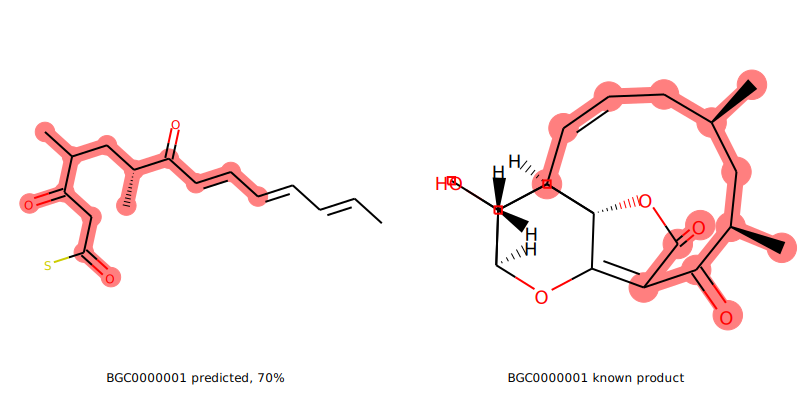

In [25]:
highlightAtomLists = highlightAtomLists[0:2]
s1 = structures[0]
s2= structures[1]

AllChem.GenerateDepictionMatching2DStructure(s2,m)
# plot predictions alongside known products
Draw.MolsToGridImage([s1, s2], highlightAtomLists=highlightAtomLists, 
                     legends = legends, molsPerRow=2,
                     subImgSize=(400, 400), useSVG=True)

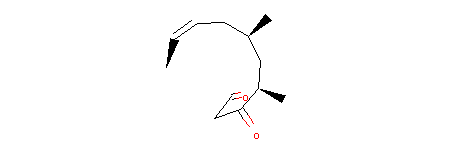

In [46]:
m = deepcopy(s2)
AllChem.Compute2DCoords(m)
atoms = [atom.GetIdx() for atom in m.GetAtoms()]
nonMCSatoms = list(filter(lambda x: x not in highlightAtomLists[1], atoms))
nonMCSatoms.sort(reverse=True)
rwmol = Chem.RWMol(m)
for atom in nonMCSatoms:
    rwmol.RemoveAtom(atom)
new_mol = rwmol.GetMol()
new_mol

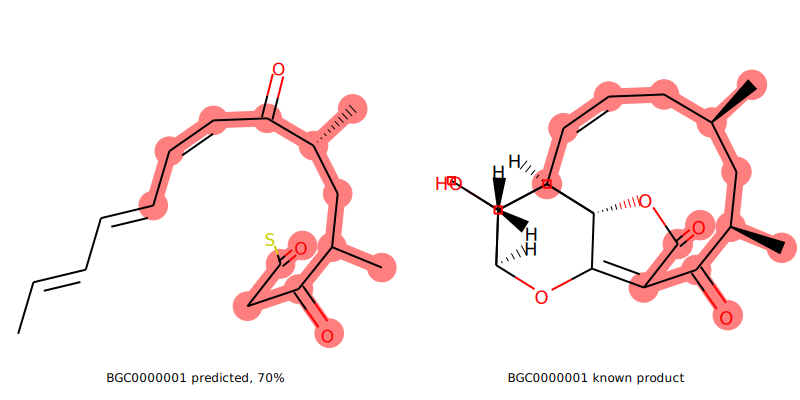

In [47]:
AllChem.GenerateDepictionMatching2DStructure(s1,new_mol)
highlightAtomLists = highlightAtomLists[0:2]
# plot predictions alongside known products
Draw.MolsToGridImage([s1, s2], highlightAtomLists=highlightAtomLists, 
                     legends = legends, molsPerRow=2,
                     subImgSize=(400, 400), useSVG=True)